# Naive Bayes Classifier

## Theoretical Foundation

The Naive Bayes classifier is a probabilistic machine learning algorithm based on **Bayes' Theorem** with a strong (naive) independence assumption between features. Despite its simplicity, it performs remarkably well in many real-world applications, particularly text classification and spam filtering.

### Bayes' Theorem

The foundation of Naive Bayes is Bayes' theorem, which describes the probability of an event based on prior knowledge of conditions related to the event:

$$P(C_k | \mathbf{x}) = \frac{P(\mathbf{x} | C_k) P(C_k)}{P(\mathbf{x})}$$

Where:
- $P(C_k | \mathbf{x})$ is the **posterior probability** of class $C_k$ given feature vector $\mathbf{x}$
- $P(\mathbf{x} | C_k)$ is the **likelihood** of observing $\mathbf{x}$ given class $C_k$
- $P(C_k)$ is the **prior probability** of class $C_k$
- $P(\mathbf{x})$ is the **evidence** (normalizing constant)

### The Naive Independence Assumption

The "naive" aspect assumes that all features are conditionally independent given the class label. For a feature vector $\mathbf{x} = (x_1, x_2, \ldots, x_n)$:

$$P(\mathbf{x} | C_k) = \prod_{i=1}^{n} P(x_i | C_k)$$

This simplification reduces the computational complexity from exponential to linear in the number of features.

### Classification Rule

The classifier assigns the class with the highest posterior probability:

$$\hat{y} = \arg\max_{C_k} P(C_k) \prod_{i=1}^{n} P(x_i | C_k)$$

Since $P(\mathbf{x})$ is constant for all classes, we can ignore it for classification purposes.

### Gaussian Naive Bayes

For continuous features, we assume each feature follows a Gaussian (normal) distribution:

$$P(x_i | C_k) = \frac{1}{\sqrt{2\pi\sigma_{k,i}^2}} \exp\left(-\frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2}\right)$$

Where $\mu_{k,i}$ and $\sigma_{k,i}^2$ are the mean and variance of feature $i$ for class $k$, estimated from training data.

### Log-Likelihood Formulation

To avoid numerical underflow from multiplying many small probabilities, we use logarithms:

$$\log P(C_k | \mathbf{x}) \propto \log P(C_k) + \sum_{i=1}^{n} \log P(x_i | C_k)$$

## Implementation

We will implement a Gaussian Naive Bayes classifier from scratch and demonstrate it on a synthetic dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes Classifier implementation.
    
    Assumes features are continuous and follow Gaussian distributions.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.variances = None
    
    def fit(self, X, y):
        """
        Fit the Naive Bayes model to training data.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training feature matrix
        y : array-like, shape (n_samples,)
            Target class labels
        """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Initialize parameters
        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        
        # Calculate statistics for each class
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors[idx] = X_c.shape[0] / n_samples
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0) + 1e-9  # Add small value for numerical stability
    
    def _calculate_likelihood(self, x, mean, var):
        """
        Calculate Gaussian likelihood P(x|C).
        
        Uses log-likelihood for numerical stability.
        """
        return -0.5 * np.sum(np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)
    
    def _calculate_posterior(self, x):
        """
        Calculate posterior probability for each class.
        
        Returns log-posteriors (unnormalized).
        """
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            likelihood = self._calculate_likelihood(x, self.means[idx], self.variances[idx])
            posterior = prior + likelihood
            posteriors.append(posterior)
        
        return posteriors
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted class labels
        """
        y_pred = []
        for x in X:
            posteriors = self._calculate_posterior(x)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.
        
        Returns normalized probabilities using softmax.
        """
        probas = []
        for x in X:
            posteriors = np.array(self._calculate_posterior(x))
            # Apply softmax for normalization
            exp_posteriors = np.exp(posteriors - np.max(posteriors))
            probas.append(exp_posteriors / exp_posteriors.sum())
        return np.array(probas)

## Synthetic Dataset Generation

We create a two-class classification problem with two features. Each class is generated from a distinct multivariate Gaussian distribution.

In [3]:
def generate_synthetic_data(n_samples_per_class=200):
    """
    Generate synthetic 2D Gaussian data for binary classification.
    
    Class 0: centered at (2, 2)
    Class 1: centered at (6, 6)
    """
    # Class 0 parameters
    mean_0 = [2, 2]
    cov_0 = [[1.5, 0.5], [0.5, 1.5]]
    
    # Class 1 parameters
    mean_1 = [6, 6]
    cov_1 = [[1.5, -0.5], [-0.5, 1.5]]
    
    # Generate samples
    X_0 = np.random.multivariate_normal(mean_0, cov_0, n_samples_per_class)
    X_1 = np.random.multivariate_normal(mean_1, cov_1, n_samples_per_class)
    
    # Combine data
    X = np.vstack([X_0, X_1])
    y = np.hstack([np.zeros(n_samples_per_class), np.ones(n_samples_per_class)])
    
    return X, y

# Generate data
X, y = generate_synthetic_data(200)

# Split into training and test sets
n_train = 300
indices = np.random.permutation(len(X))
X_train, X_test = X[indices[:n_train]], X[indices[n_train:]]
y_train, y_test = y[indices[:n_train]], y[indices[n_train:]]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 300
Test samples: 100


## Model Training and Evaluation

In [4]:
# Train the Gaussian Naive Bayes classifier
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Display learned parameters
print("\nLearned Parameters:")
print(f"Class priors: {gnb.priors}")
print(f"\nClass 0 - Mean: {gnb.means[0]}, Variance: {gnb.variances[0]}")
print(f"Class 1 - Mean: {gnb.means[1]}, Variance: {gnb.variances[1]}")

Test Accuracy: 1.0000

Learned Parameters:
Class priors: [0.49666667 0.50333333]

Class 0 - Mean: [1.99006751 2.0583801 ], Variance: [1.46638314 1.43615504]
Class 1 - Mean: [6.05786767 5.94486727], Variance: [1.54431446 1.48552585]


## Visualization

We visualize the decision boundary and class distributions to understand how the Naive Bayes classifier partitions the feature space.

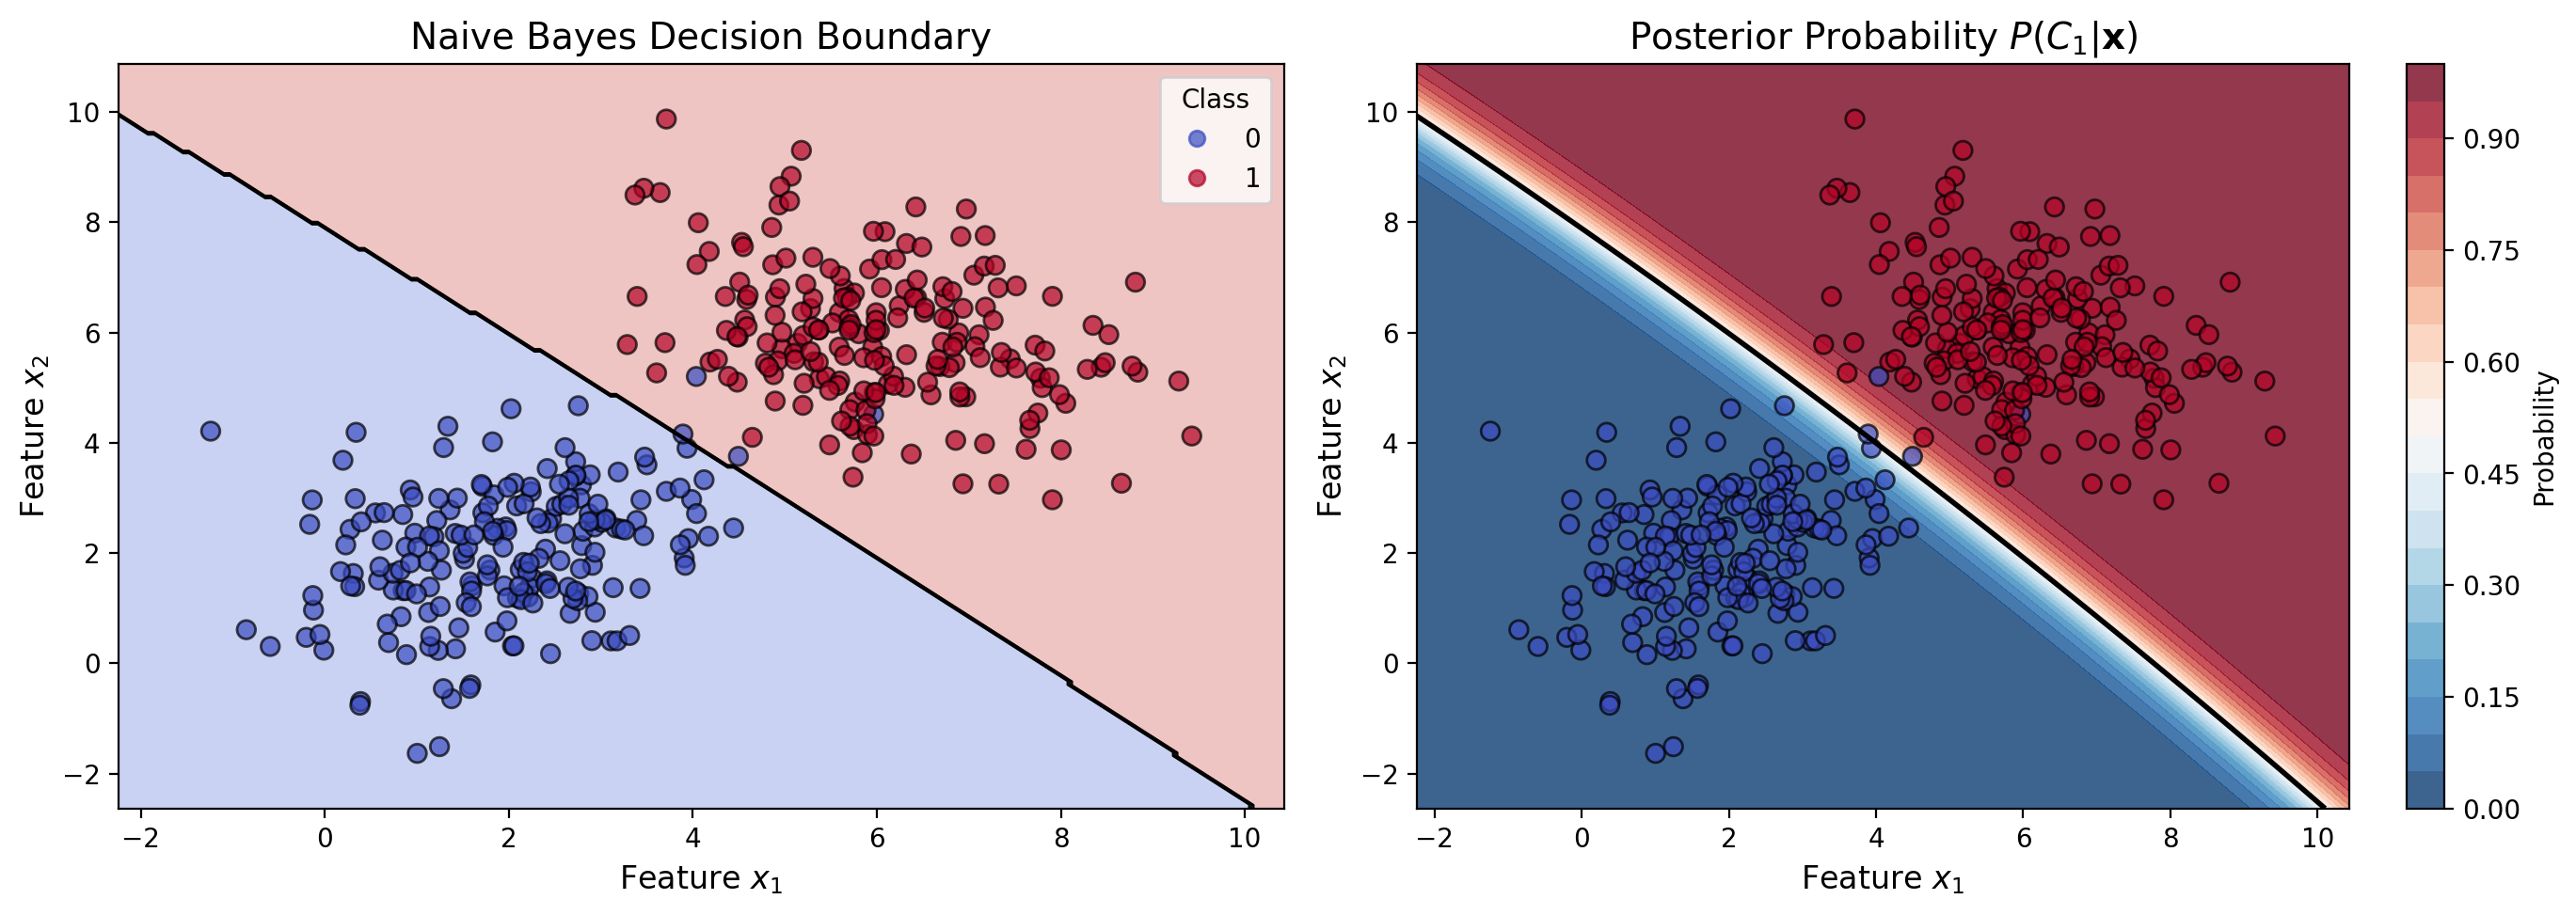


Plot saved to 'plot.png'


In [5]:
def plot_decision_boundary(model, X, y, title="Naive Bayes Decision Boundary"):
    """
    Plot the decision boundary and data points.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict on mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax1 = axes[0]
    ax1.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax1.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # Plot data points
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', 
                          edgecolors='k', alpha=0.7, s=50)
    ax1.set_xlabel('Feature $x_1$', fontsize=12)
    ax1.set_ylabel('Feature $x_2$', fontsize=12)
    ax1.set_title(title, fontsize=14)
    ax1.legend(*scatter.legend_elements(), title="Class")
    
    # Plot probability contours
    ax2 = axes[1]
    proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    proba = proba.reshape(xx.shape)
    
    contour = ax2.contourf(xx, yy, proba, levels=20, cmap='RdBu_r', alpha=0.8)
    ax2.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=2)
    ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', 
                edgecolors='k', alpha=0.7, s=50)
    ax2.set_xlabel('Feature $x_1$', fontsize=12)
    ax2.set_ylabel('Feature $x_2$', fontsize=12)
    ax2.set_title('Posterior Probability $P(C_1|\mathbf{x})$', fontsize=14)
    plt.colorbar(contour, ax=ax2, label='Probability')
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_decision_boundary(gnb, X, y)

# Save the plot
plt.savefig('naive_bayes_classifier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Confusion Matrix and Classification Report

In [6]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics manually.
    """
    # Confusion matrix elements
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'confusion_matrix': np.array([[tn, fp], [fn, tp]]),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Calculate and display metrics
metrics = calculate_metrics(y_test, y_pred)

print("Confusion Matrix:")
print(metrics['confusion_matrix'])
print(f"\nAccuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-Score:  {metrics['f1_score']:.4f}")

Confusion Matrix:
[[51  0]
 [ 0 49]]

Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


## Analysis of the Naive Independence Assumption

The Naive Bayes classifier assumes features are conditionally independent given the class. Let's examine when this assumption holds and its implications.

In [7]:
# Calculate feature correlation for each class
print("Feature Correlation Analysis:")
print("="*40)

for class_label in [0, 1]:
    X_class = X_train[y_train == class_label]
    correlation = np.corrcoef(X_class[:, 0], X_class[:, 1])[0, 1]
    print(f"Class {int(class_label)}: Correlation between features = {correlation:.4f}")

print("\nNote: The naive independence assumption is violated when features are correlated.")
print("However, Naive Bayes often performs well despite this violation.")

Feature Correlation Analysis:
Class 0: Correlation between features = 0.2785
Class 1: Correlation between features = -0.3648

Note: The naive independence assumption is violated when features are correlated.
However, Naive Bayes often performs well despite this violation.


## Summary

### Key Properties of Naive Bayes:

1. **Computational Efficiency**: Training is $O(nd)$ where $n$ is samples and $d$ is features

2. **Interpretable**: Learned parameters (means, variances, priors) have clear probabilistic meaning

3. **Works with Small Data**: Requires less training data than more complex models

4. **Robust to Irrelevant Features**: Irrelevant features contribute equally across classes

### Limitations:

1. **Independence Assumption**: Features are rarely truly independent in practice

2. **Probability Estimates**: May be poorly calibrated due to the naive assumption

3. **Zero Probability Problem**: Requires smoothing (Laplace) for discrete features

### Applications:

- Spam filtering
- Document classification
- Sentiment analysis
- Medical diagnosis
- Real-time prediction systems